# Presentation of the Creation of:
## FareSync: *A Dynamic Pricing Product*

Dynamic pricing is a critical tool of modern businesses. It allows for real-time price adjustments based on customer needs maximizing revenue, optimizing resources, and enabling swift responses to customer demand.

The goal of this project to bring this advantage to *Ride*, an up-and-coming (fictional) Ride-Share company. That has until now relied on fixed pricing and the avilability of their drivers to meet their customers. They have come to me with complaints of barely staying in the green even with a skeleton crew.

###**The goal**
To prove the value of dynamic pricing.

Then create a dynamic priving product for ride to be deployed as a dashboard as a tool to inform their pricing strategies.



### **The Plan**

To answer the following questions using scientific tests on the data available:

* Is the difference between between the Revenue of Fixed Pricing and Revenue of Dynamic Pricing significant?

* What are the key factors affecting price in the competitor's dynamic pricing model?

* How can we accurately forecast ride pricing based on current conditions?

Once these questions are answered the models that were used to answer the questions will be packaged into a deployable dashboard for *Ride*'s team to use.


### **The Data**

#### Dynamic Pricing Dataset
In a real-world scenario I would either purchase access to guaranteed genuine  information or have access to *Ride*’s beta proprietary data.

For the purpose of this project, in lieu of genuine company data, I will use Kaggle’s API to access and download [Synthetic Ride-Sharing Dataset for Dynamic Pricing](https://www.kaggle.com/datasets/vasupradha2003/synthetic-ride-sharing-dataset-for-dynamic-pricing) to represent a competitor's dynamic pricing dataset.

The synthetic dataset in CSV format created for academic purposes. It is made up of 7 features and 1000 observation.

The features include:
* Distance:  the distnace of ride in kilometers
* Time of Day: Time of the ride, categorized into Morning, Afternoon, Evening, and Night
* Demand: A score indicating demand during the time period.
* Weather: String categorical variable representing weather: Clear, Rainy, or Snowy)
* Base Price: Base price for the ride in local
* Weather Multiplier: A multiplier applied to the base price based on weather conditions.
* Final price of the ride after applying the weather multiplier.


#### *Ride*'s fixed Price Dataset
 A pandas datafame created with 1000 'rides' (oberservations) priced at the average of the Dynamic Dataset's`Final_Price` feature. It is assumed that the underlying conditions (e.g. date, time of day, weather, demand, etc.) of these datasets are the same.



This project begins with importing the Python libraries and modules necessary to perform the task at hand.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from statsmodels.tsa.arima.model import ARIMA
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vasupradha2003/synthetic-ride-sharing-dataset-for-dynamic-pricing")

print("Path to dataset files:", path)

100%|██████████| 25.3k/25.3k [00:00<00:00, 28.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/vasupradha2003/synthetic-ride-sharing-dataset-for-dynamic-pricing/versions/1


Here the competitor's Dynamic Pricing Data is being loaded.

In [ ]:
# load data
df = pd.read_csv(path + "/ride_sharing_data.csv")

# check the loaded data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Distance            1000 non-null   float64
 1   Time_of_Day         1000 non-null   object 
 2   Demand              1000 non-null   float64
 3   Weather             1000 non-null   object 
 4   Base_Price          1000 non-null   int64  
 5   Weather_Multiplier  1000 non-null   float64
 6   Price               1000 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 54.8+ KB


We can observe that beyond prices they've collected data on Distance, Time of Day, Demand, Weather, Base Price, Weather Multiplier, and Price.

Also based on this information there doesn't appear to be any null values.

The competitor's data source infomation indicated that the distance was in KM and the prices are in local currency (CAD). *Ride* is an American company so the distance needs to be updated to msiles and the curreny to American Dollars.

In [ ]:
# Convert the KM Distance to Miles and update df
df['Distance_Miles'] =(df['Distance'] * 0.62).round(2)
df.drop(columns=['Distance'], inplace=True)

# Convert CAD to USD and update df
df['Base_Price_USD'] = (df['Base_Price'] * 0.69).round(2)
df.drop(columns=['Base_Price'], inplace=True)

df['Final_Price_USD'] = (df['Price']*.69).round(2)
df.drop(columns=['Price'], inplace=True)

In [ ]:
# Check for accuracy
df.head()

,Time_of_Day,Demand,Weather,Weather_Multiplier,Distance_Miles,Base_Price_USD,Final_Price_USD
0,Evening,5.671736,Snowy,2.0,5.03,8.28,210.64
1,Night,5.312637,Snowy,2.0,11.82,10.35,604.26
2,Afternoon,1.230779,Snowy,2.0,9.24,5.52,184.84
3,Night,4.071230,Snowy,2.0,7.67,10.35,360.44
4,Night,4.421761,Snowy,2.0,2.46,10.35,118.35


# Now that the data is in Miles and USD we can compare Revenues.

In a typical business scenario there would be historical data for the client, *Ride*. However, because *Ride* is a fictional company the data must be created.

For simplicity the average of the Final_Price_USD from the competitor's data will be used to represent the average of `Final_Price` from `df` for `10000` observations creating  the Fixed Price Dataset `fixed_df` (*Ride*'s data).

This is done with the assumption that all other factors are the same (weather conditions, demand, timespan, etc).

Now we have values to compare to a good idea of the significance of Dynamic pricing.

In [ ]:
fixed_df = df.copy()
fixed_df['Final'] = fixed_df['Final_Price_USD'].mean()
fixed_df.drop(columns=['Demand','Weather', 'Time_of_Day','Weather_Multiplier','Distance_Miles', 'Base_Price_USD', 'Final_Price_USD'], inplace=True)

## Is the difference between between the Revenue of Fixed Pricing and Revenue of Dynamic Pricing significant?

###**Null Hypothesis**
##H0: The difference between the Revenues is not significant.
###**Alternative Hypothesis**
##H1: Dynamic pricing significantly impacts revenue.

Visualize *Ride*'s Fixed Pricing Revenue per ride.

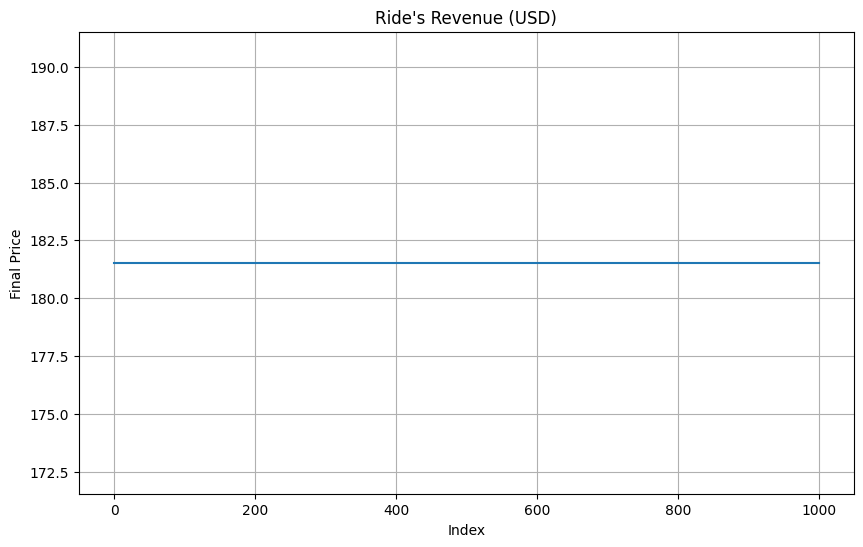

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fixed_df['Final'])
plt.xlabel('Index')
plt.ylabel('Final Price')
plt.title("Ride's Revenue (USD)")
plt.grid(True)
plt.show()

Visualize the Competitor's Revenue Per Ride.

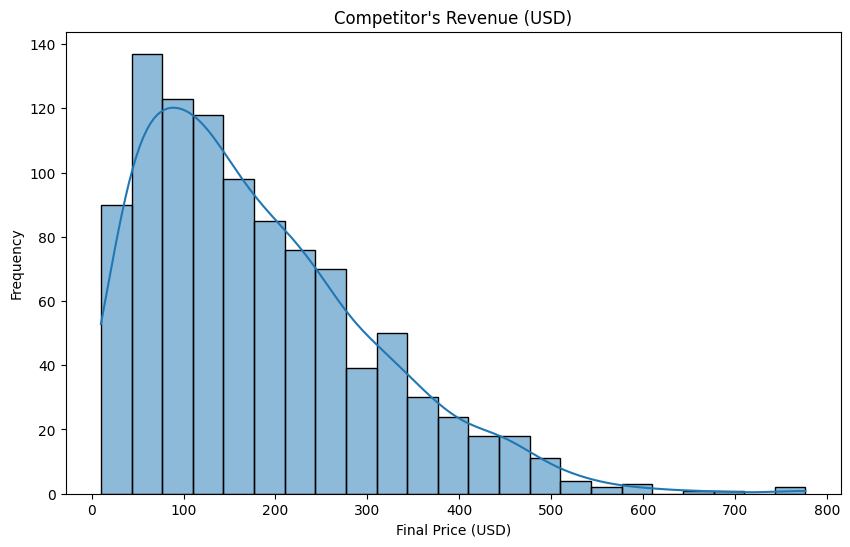

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Final_Price_USD'], kde=True)
plt.title("Competitor's Revenue (USD)")
plt.xlabel('Final Price (USD)')
plt.ylabel('Frequency')
plt.show()

The difference between the two is apparent visually, but is it significant scientifically?

# Statistical Significance of Dynamic Pricing

In [ ]:
Fixed_Revenue = fixed_df['Final']
Dynamic_Revenue = df['Final_Price_USD']


statistic, p_value = stats.mannwhitneyu(Dynamic_Revenue, Fixed_Revenue)

# Print the results
print('Mann-Whitney U statistic: {}'.format(statistic))
print('P value: {}'.format(p_value))

# Interpret the results
alpha = 0.05
if p_value < alpha:
  print('Reject the null hypothesis. Dynamic Pricing has a significant impact on Revenue.')
else:
  print('Fail to rejct the null hypothesis. Dynamic Pricing has no impact on Revenue.')

Mann-Whitney U statistic: 422000.0
P value: 1.065468040172332e-10
Reject the null hypothesis. Dynamic Pricing has a significant impact on Revenue.


As demonstrated within the output of the code, Dynamic Pricing has a significant impact on Revenue.

Below is a visualization of both Revenues for a complete image.

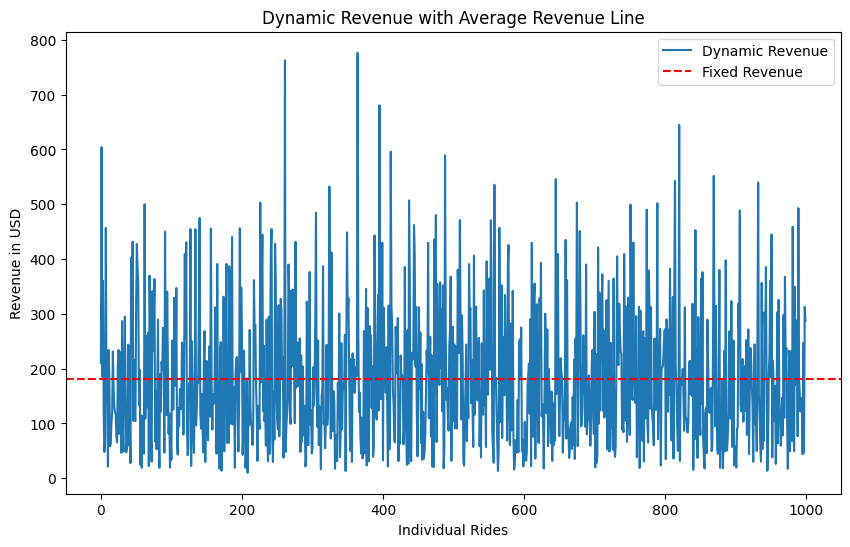

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Dynamic_Revenue, label='Dynamic Revenue')
plt.axhline(y=181.53, color='r', linestyle='--', label='Fixed Revenue')
plt.xlabel('Individual Rides')
plt.ylabel('Revenue in USD')
plt.title('Dynamic Revenue with Average Revenue Line')
plt.legend()
plt.show()

In [ ]:
Fixed_Revenue = fixed_df['Final']
Dynamic_Revenue = df['Final_Price_USD']

# Calculate the numerical difference
revenue_difference = np.sum(Dynamic_Revenue) - np.sum(Fixed_Revenue)

print(f"The numerical difference between dynamic and fixed revenue is: {revenue_difference}")

print(revenue_difference * 10000)




The numerical difference between dynamic and fixed revenue is: -2.9103830456733704e-11
-2.9103830456733704e-07


### The first question has been answered, a deeper analysis will begin to answer the remaining questions.

## The next question:
##_What are the key factors affecting the prices in the dynamic pricing model?_


In [ ]:
# Get the spread of the numeric data
df.describe()

,Demand,Weather_Multiplier,Distance_Miles,Base_Price_USD,Final_Price_USD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.483440,1.491500,6.395210,7.706610,181.532780
std,2.576445,0.412126,3.441556,1.780293,125.606099
min,1.014086,1.000000,0.670000,5.520000,10.030000
25%,3.310508,1.000000,3.397500,5.520000,82.007500
50%,5.550885,1.500000,6.475000,6.900000,154.010000
75%,7.642966,2.000000,9.385000,8.280000,252.885000
max,9.985128,2.000000,12.400000,10.350000,776.560000


The Spread:
Examing the we learn:
* **Demand** range: `1` and `9.985`, _average_: `5.48`
* **Weather_Multiplier**: Range: `1` and `2`, _average_ `1.5`
* **Distance_Miles**: Range: `0.67` and `12.40`, _average_: `6.40`
* **Base_Price_USD**: Range: `$5.52` to `$10.35`, _average_: `$7.71`
* **Final_Price_USD**: Range: `$10.03` to `$776.56`, _average_: `$181.53`

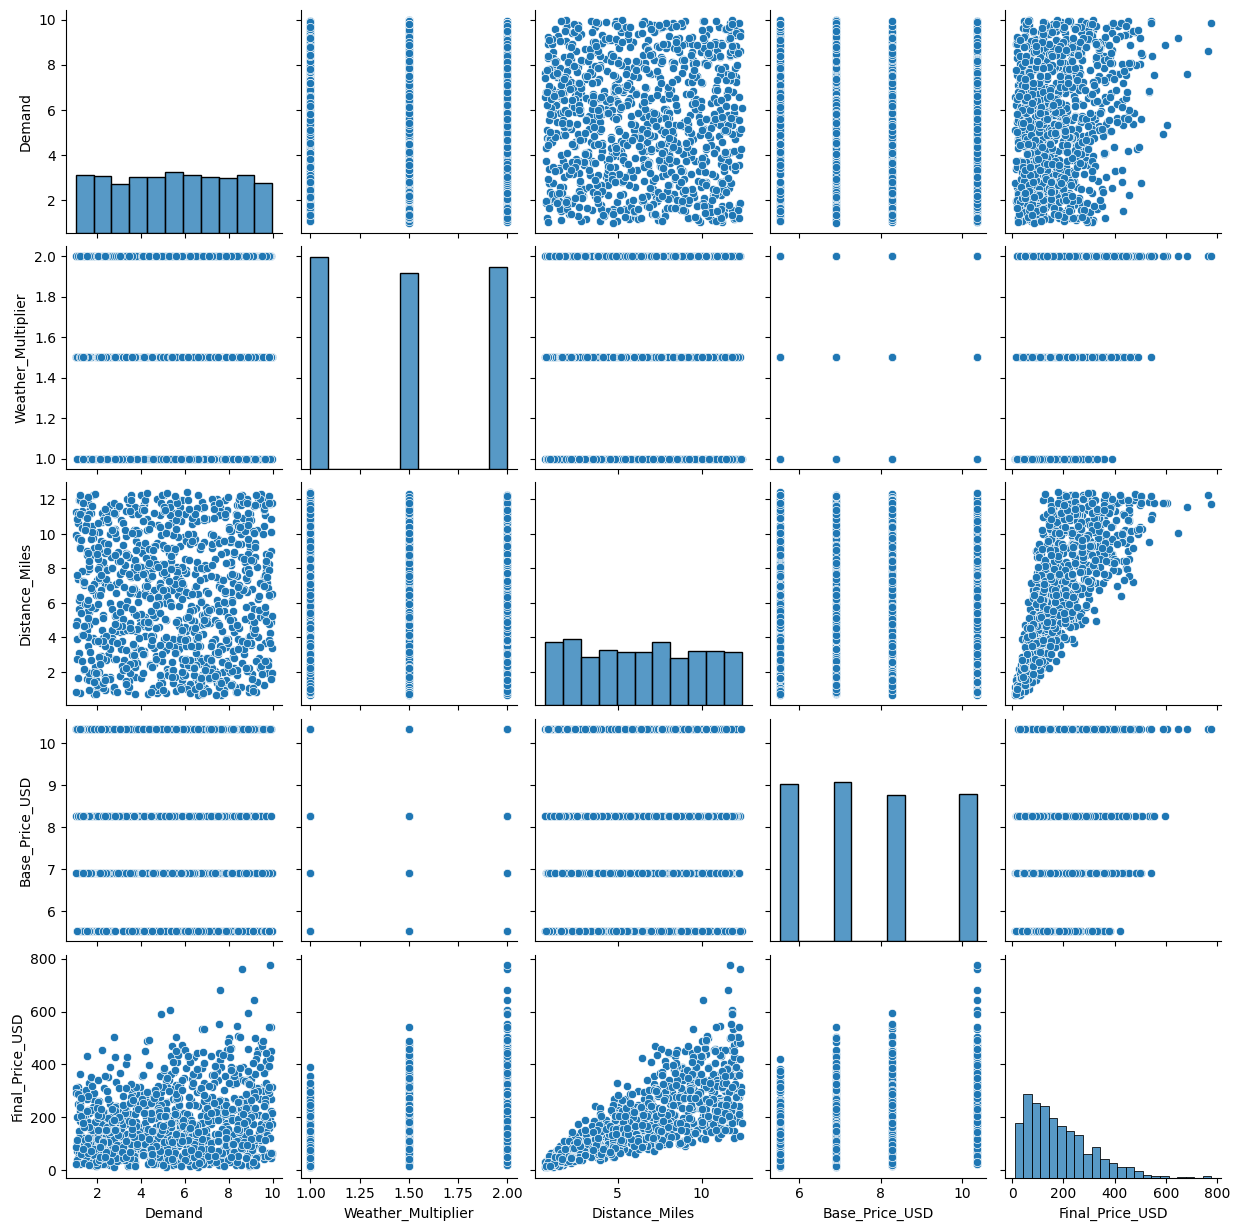

In [ ]:
# Let's visualize our numerical data
sns.pairplot(df)
plt.show()

Final_Price_USD appears to be highly left skewed so to get a better understanding we will need to scale the pricing.

Also the data appears linear in nature so we will try linear regression for out first model.

In [ ]:
# Now to take a look at the non-numerical data
df.describe(include='object')

,Time_of_Day,Weather
count,1000,1000
unique,4,3
top,Morning,Clear
freq,261,348


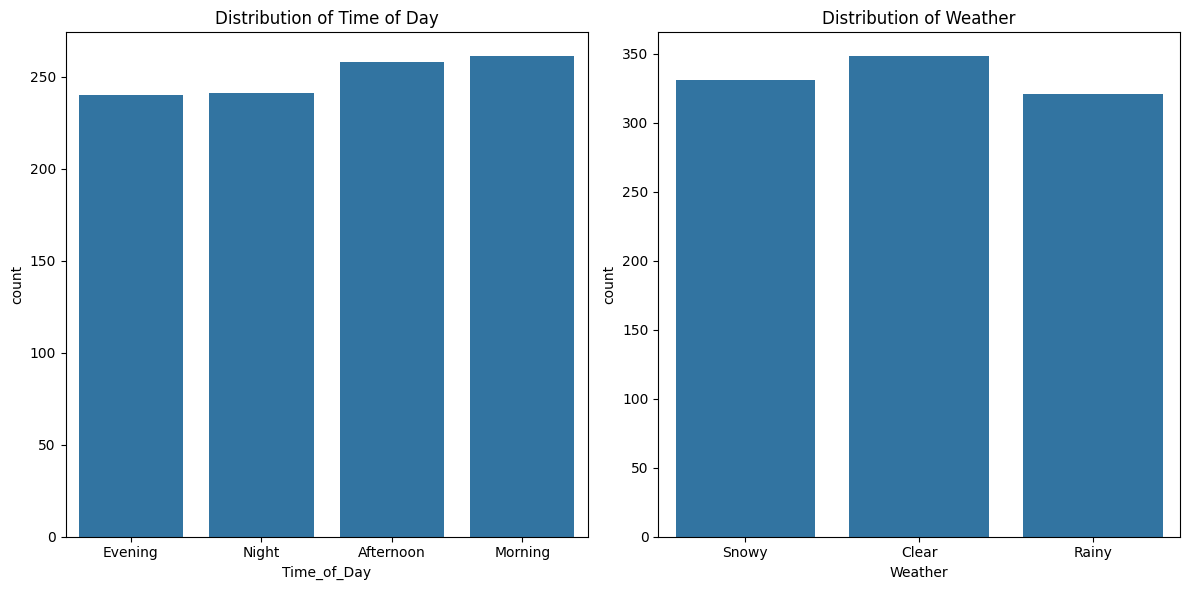

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='Time_of_Day', data=df)
plt.title('Distribution of Time of Day')

plt.subplot(1, 2, 2)
sns.countplot(x='Weather', data=df)
plt.title('Distribution of Weather')

plt.tight_layout()
plt.show()

For the categorical data to be useful it must be converted to numerical data.

In [ ]:
df = pd.get_dummies(df, columns=['Time_of_Day', 'Weather'], drop_first=True, dtype='int')

In [ ]:
# Get the names of our new numerical features
df.head()

,Demand,Weather_Multiplier,Distance_Miles,Base_Price_USD,Final_Price_USD,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Weather_Rainy,Weather_Snowy
0,5.671736,2.0,5.03,8.28,210.64,1,0,0,0,1
1,5.312637,2.0,11.82,10.35,604.26,0,0,1,0,1
2,1.230779,2.0,9.24,5.52,184.84,0,0,0,0,1
3,4.071230,2.0,7.67,10.35,360.44,0,0,1,0,1
4,4.421761,2.0,2.46,10.35,118.35,0,0,1,0,1


In [ ]:
# Make lists of the new numerical features that correspond with their old feature name
Time_of_Day =['Time_of_Day_Morning', 'Time_of_Day_Evening', 'Time_of_Day_Night']
Weather = ['Weather_Snowy', 'Weather_Rainy']

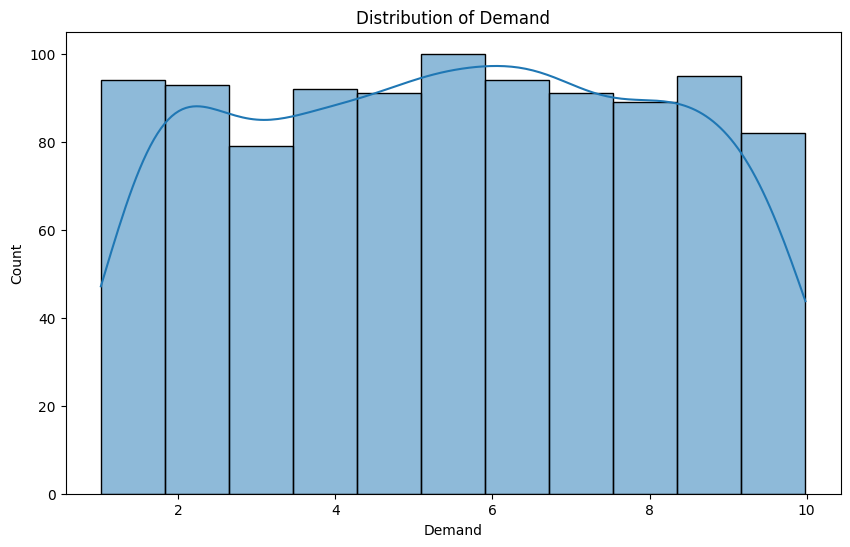

Shapiro-Wilk Test for Distribution of Demand
Statistic: 0.9572532539207822, p-value: 1.7003786580012834e-16
Distribution is likely not normal.


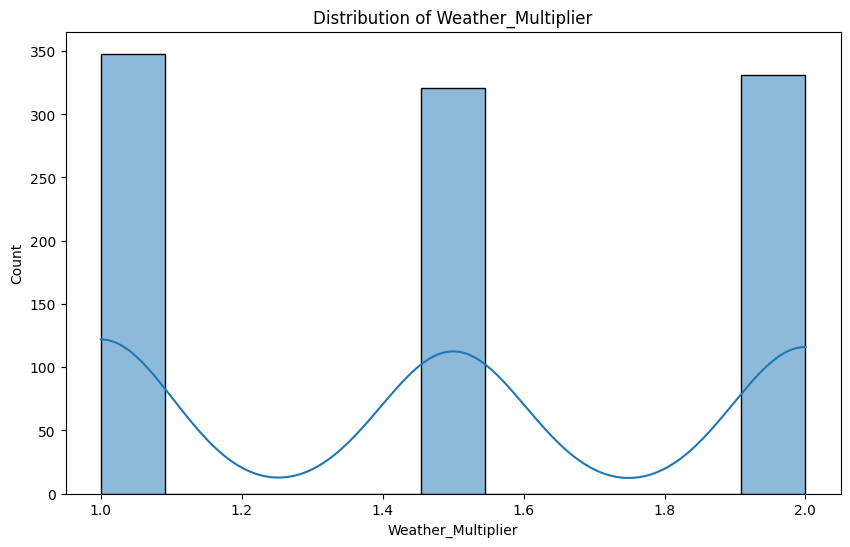

Shapiro-Wilk Test for Distribution of Weather_Multiplier
Statistic: 0.7898638401114426, p-value: 5.1662857811844575e-34
Distribution is likely not normal.


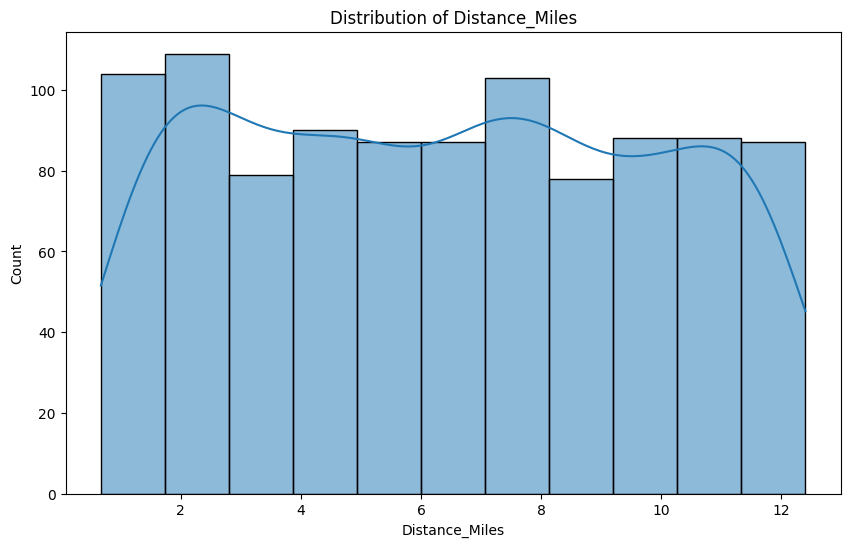

Shapiro-Wilk Test for Distribution of Distance_Miles
Statistic: 0.9500734862005747, p-value: 6.5572750857867734e-18
Distribution is likely not normal.


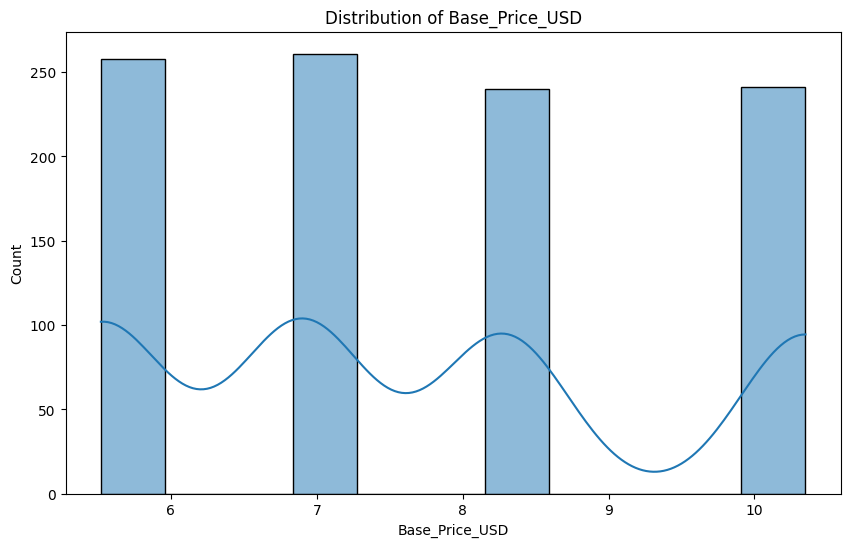

Shapiro-Wilk Test for Distribution of Base_Price_USD
Statistic: 0.8501099241276011, p-value: 9.753273738248425e-30
Distribution is likely not normal.


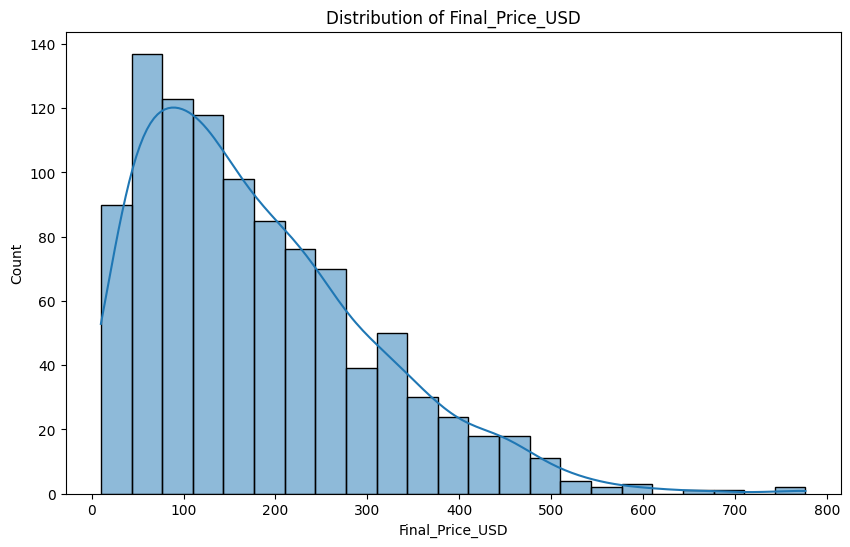

Shapiro-Wilk Test for Distribution of Final_Price_USD
Statistic: 0.9242485037991228, p-value: 5.087325131924302e-22
Distribution is likely not normal.


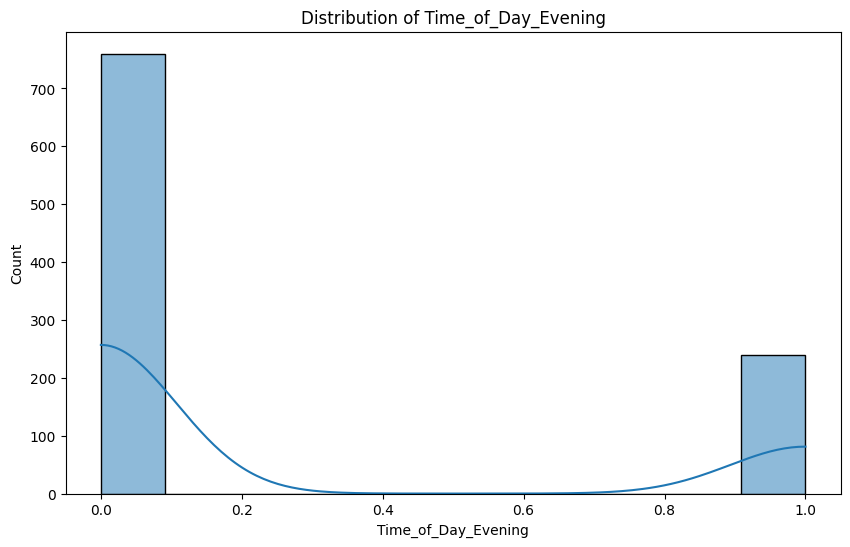

Shapiro-Wilk Test for Distribution of Time_of_Day_Evening
Statistic: 0.529759882952038, p-value: 1.994808036343016e-45
Distribution is likely not normal.


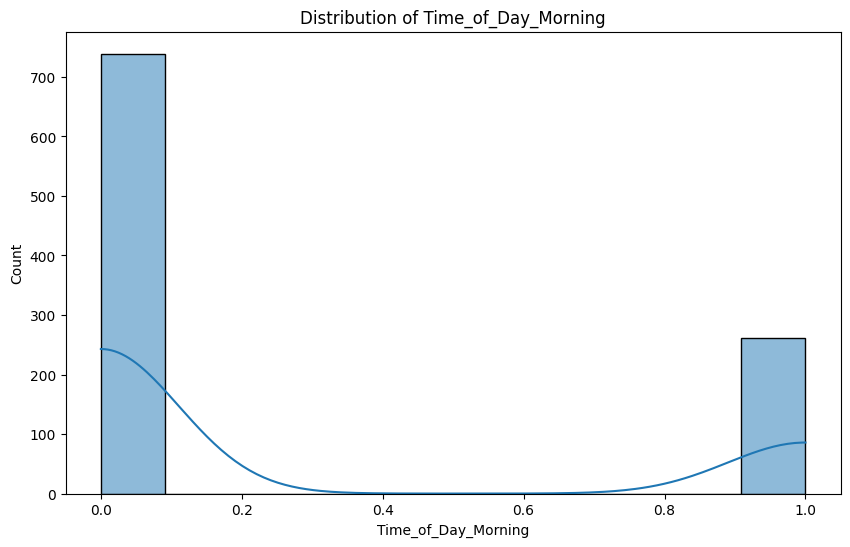

Shapiro-Wilk Test for Distribution of Time_of_Day_Morning
Statistic: 0.5475774705274123, p-value: 7.699354780620082e-45
Distribution is likely not normal.


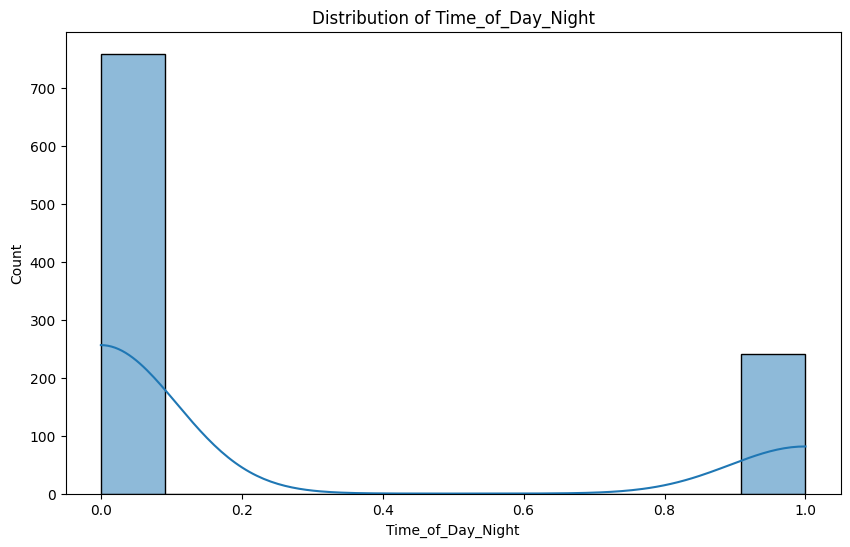

Shapiro-Wilk Test for Distribution of Time_of_Day_Night
Statistic: 0.5306549083055996, p-value: 2.132670227736618e-45
Distribution is likely not normal.


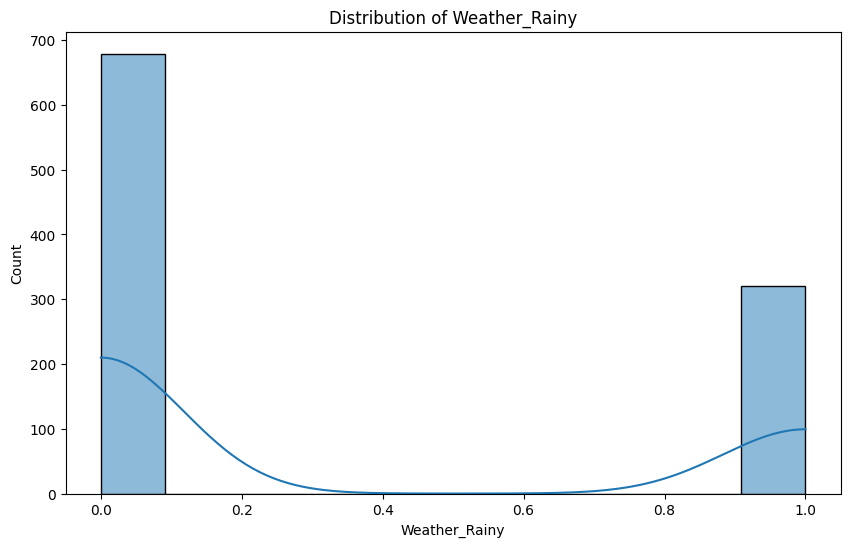

Shapiro-Wilk Test for Distribution of Weather_Rainy
Statistic: 0.5882208254808448, p-value: 1.9918595520331452e-43
Distribution is likely not normal.


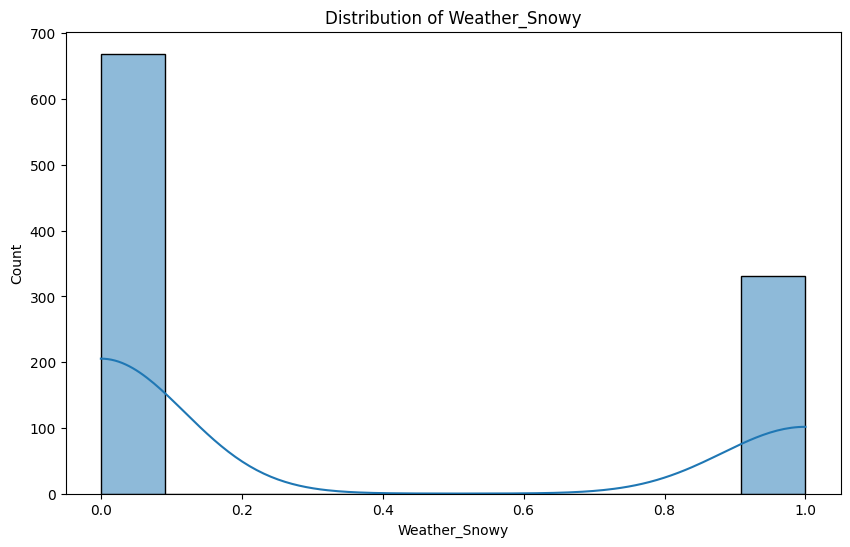

Shapiro-Wilk Test for Distribution of Weather_Snowy
Statistic: 0.5936559707680107, p-value: 3.1390310181856057e-43
Distribution is likely not normal.


In [ ]:
# Visualize the distribution of the features
for col in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

    statistic, p_value = stats.shapiro(df[col])
    print(f"Shapiro-Wilk Test for Distribution of {col}")
    print(f"Statistic: {statistic}, p-value: {p_value}")
    if p_value > 0.05:
        print("Distribution is likely normal.")
    else:
        print("Distribution is likely not normal.")

Due to the abnomality of the distrubtions of each feature they all must be standardized before moving forward.

Let's take a look at the distribution of the new features

In [ ]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

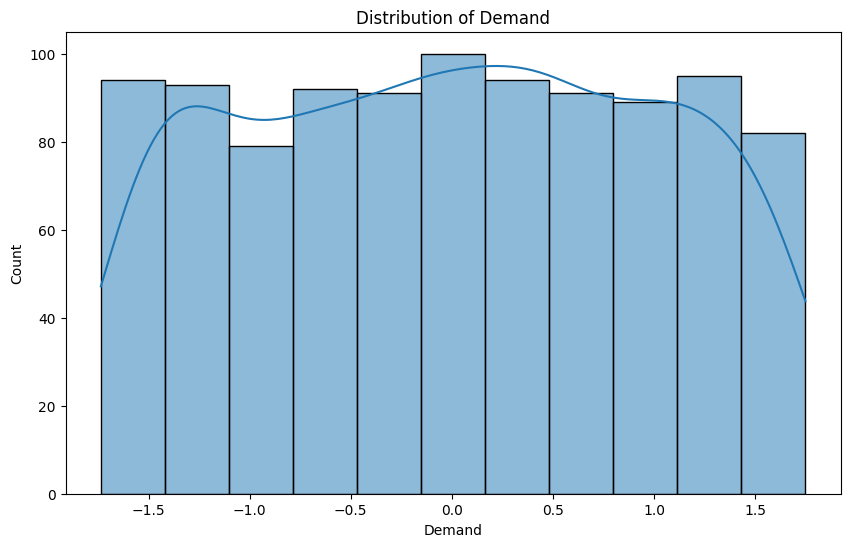

Shapiro-Wilk Test for Distribution of Demand
Statistic: 0.9572532539207819, p-value: 1.700378658000977e-16
Distribution is likely not normal.


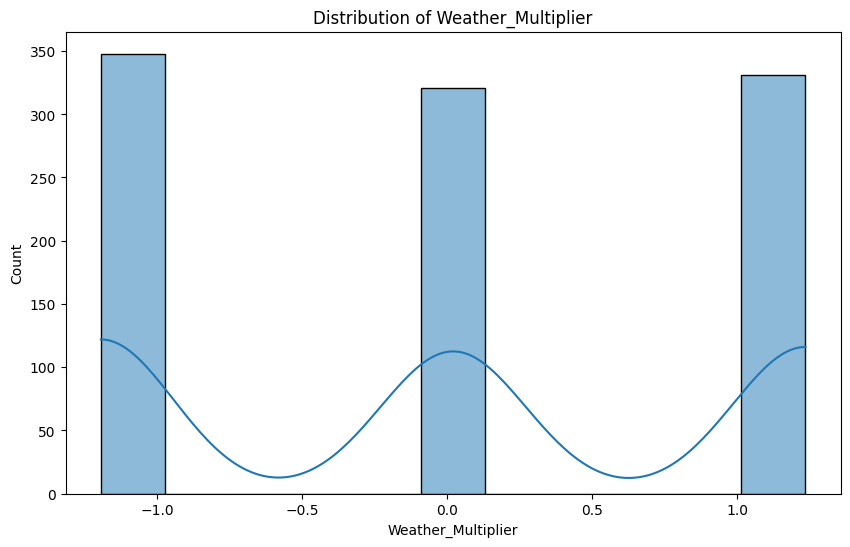

Shapiro-Wilk Test for Distribution of Weather_Multiplier
Statistic: 0.7898638401114426, p-value: 5.1662857811844575e-34
Distribution is likely not normal.


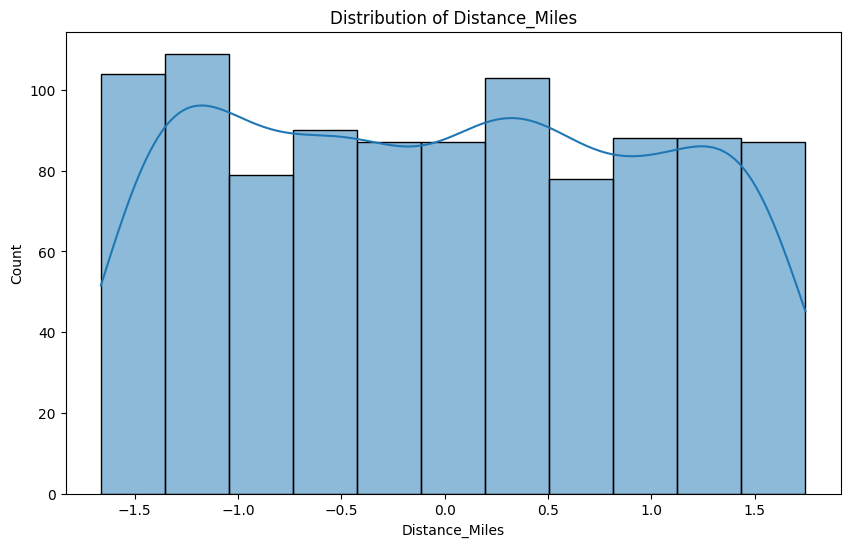

Shapiro-Wilk Test for Distribution of Distance_Miles
Statistic: 0.9500734862005747, p-value: 6.5572750857867734e-18
Distribution is likely not normal.


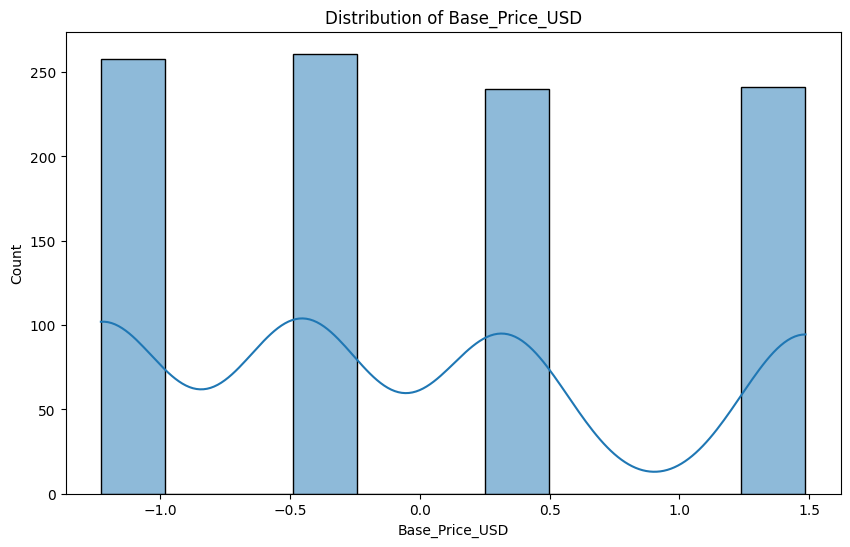

Shapiro-Wilk Test for Distribution of Base_Price_USD
Statistic: 0.8501099241276011, p-value: 9.753273738248425e-30
Distribution is likely not normal.


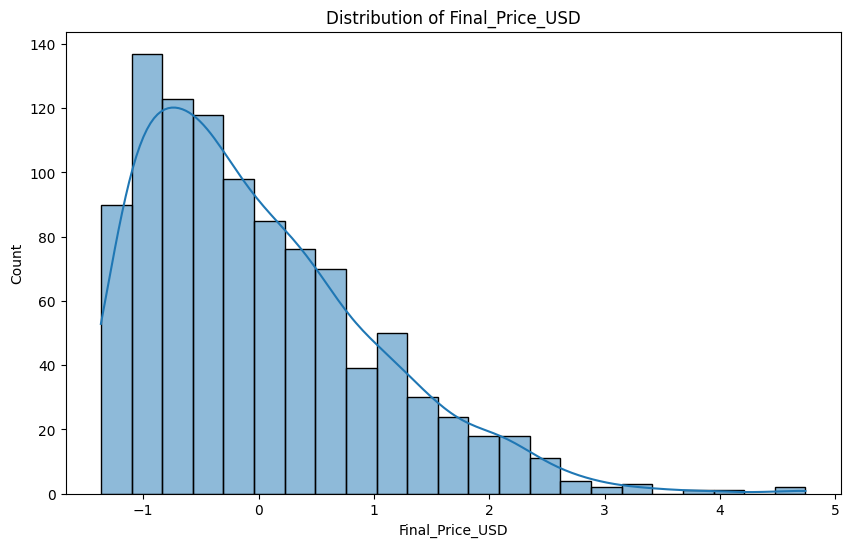

Shapiro-Wilk Test for Distribution of Final_Price_USD
Statistic: 0.9242485037991228, p-value: 5.087325131924375e-22
Distribution is likely not normal.


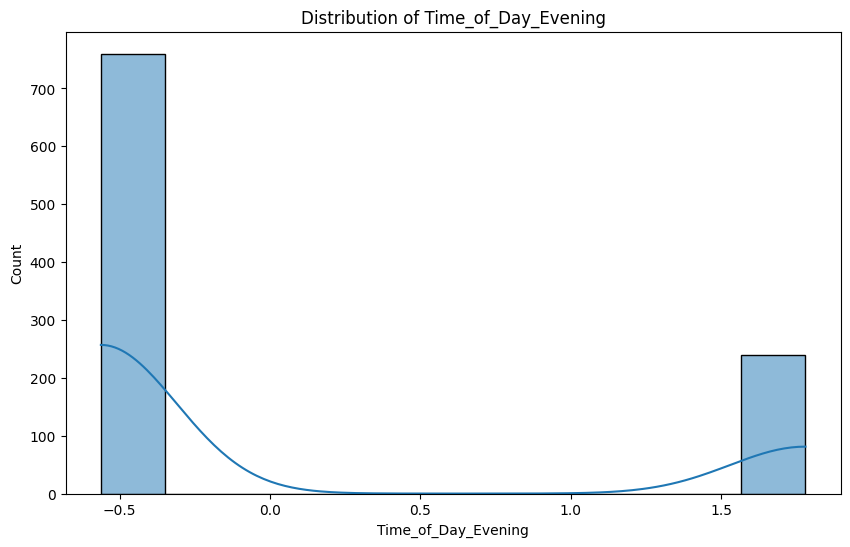

Shapiro-Wilk Test for Distribution of Time_of_Day_Evening
Statistic: 0.529759882952038, p-value: 1.994808036343016e-45
Distribution is likely not normal.


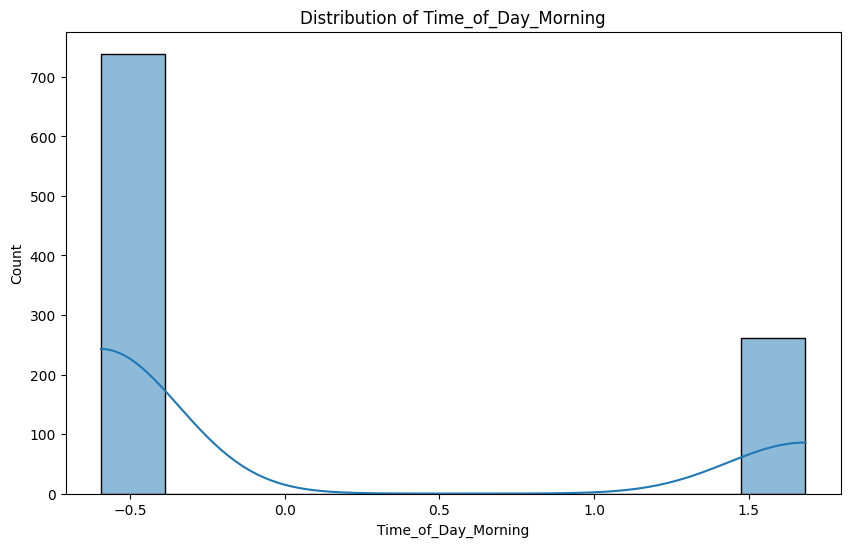

Shapiro-Wilk Test for Distribution of Time_of_Day_Morning
Statistic: 0.5475774705274123, p-value: 7.699354780620082e-45
Distribution is likely not normal.


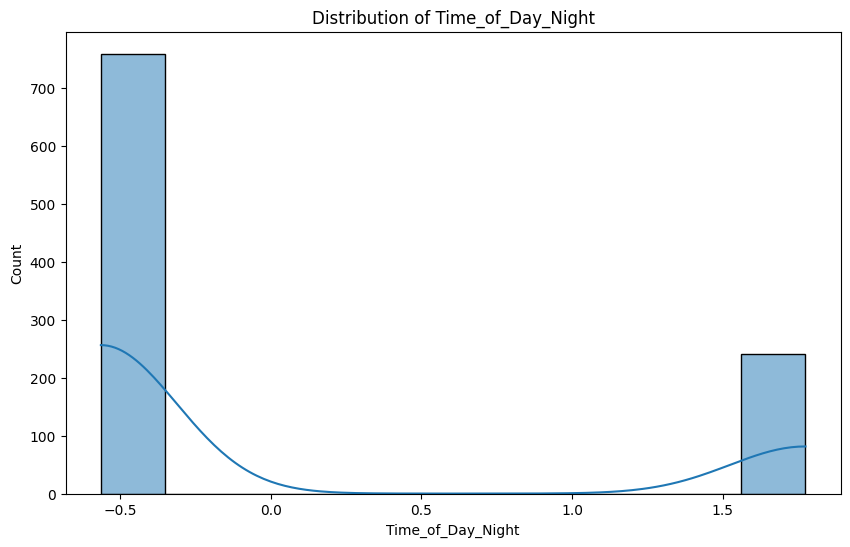

Shapiro-Wilk Test for Distribution of Time_of_Day_Night
Statistic: 0.5306549083055996, p-value: 2.132670227736618e-45
Distribution is likely not normal.


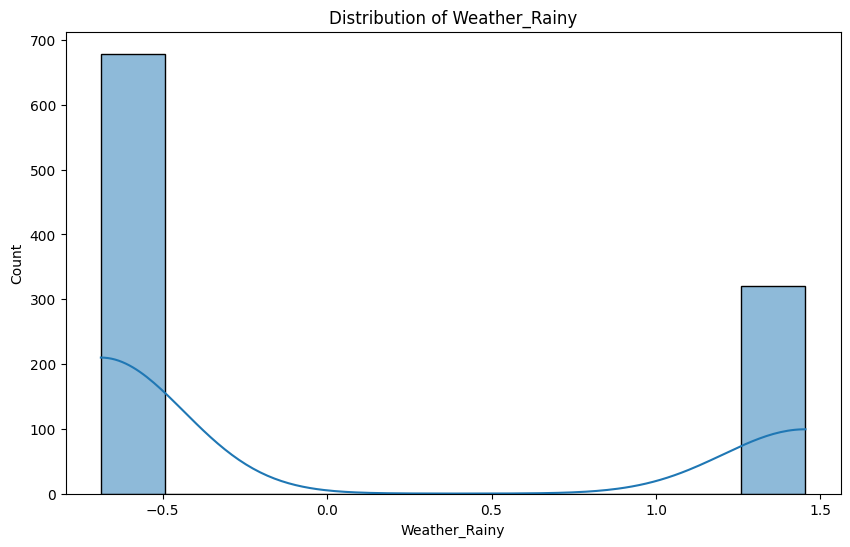

Shapiro-Wilk Test for Distribution of Weather_Rainy
Statistic: 0.5882208254808448, p-value: 1.9918595520331452e-43
Distribution is likely not normal.


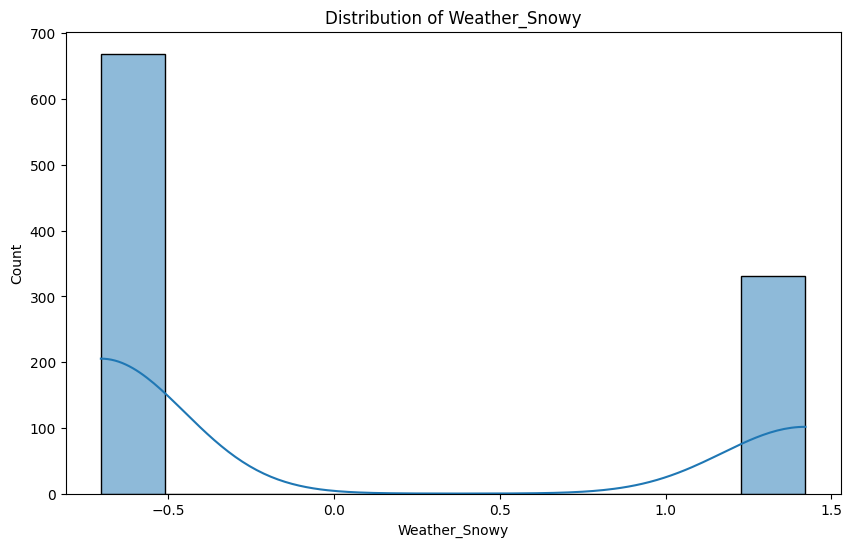

Shapiro-Wilk Test for Distribution of Weather_Snowy
Statistic: 0.5936559707680107, p-value: 3.1390310181856057e-43
Distribution is likely not normal.


In [ ]:
# take a look at the new distributions
for col in scaled_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(scaled_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

    statistic, p_value = stats.shapiro(scaled_df[col])
    print(f"Shapiro-Wilk Test for Distribution of {col}")
    print(f"Statistic: {statistic}, p-value: {p_value}")
    if p_value > 0.05:
        print("Distribution is likely normal.")
    else:
        print("Distribution is likely not normal.")

# Key Factors Affecting Prices

# Check for correlations
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

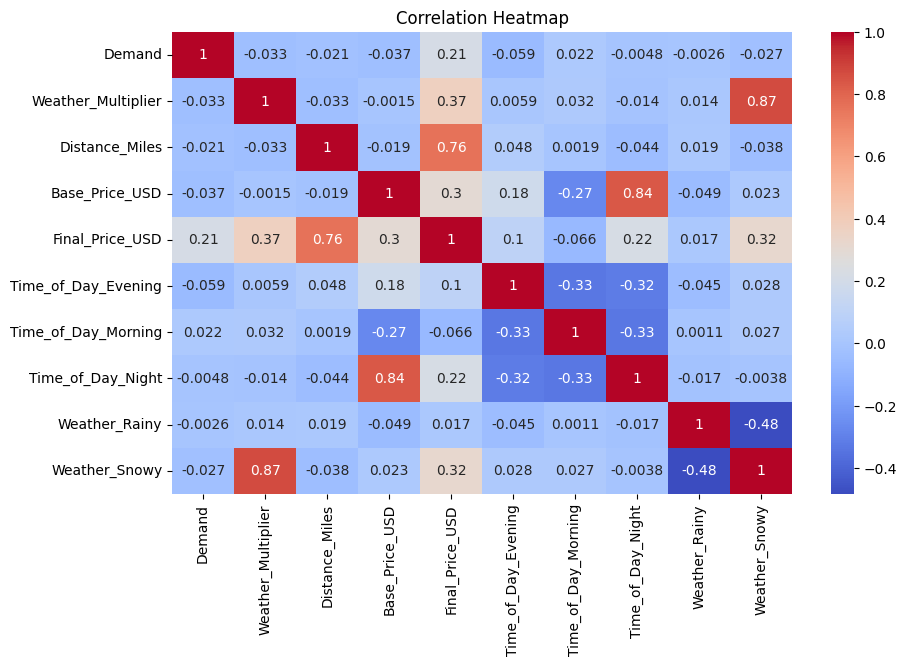

In [ ]:
scaled_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(scaled_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


There are many features that correlate with each other. Distance is highly correlated with Final Price, but not perfectly correlated so that indicates it is an important feature.

In [ ]:
correlation_matrix = scaled_df.corr()
correlation_matrix

,Demand,Weather_Multiplier,Distance_Miles,Base_Price_USD,Final_Price_USD,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Weather_Rainy,Weather_Snowy
Demand,1.000000,-0.032790,-0.021053,-0.037336,0.214130,-0.059257,0.022022,-0.004809,-0.002604,-0.027411
Weather_Multiplier,-0.032790,1.000000,-0.032567,-0.001472,0.372907,0.005912,0.031610,-0.013915,0.014188,0.868319
Distance_Miles,-0.021053,-0.032567,1.000000,-0.019160,0.758664,0.047532,0.001907,-0.044186,0.018605,-0.037737
Base_Price_USD,-0.037336,-0.001472,-0.019160,1.000000,0.296847,0.181082,-0.269394,0.837095,-0.049212,0.023123
Final_Price_USD,0.214130,0.372907,0.758664,0.296847,1.000000,0.099507,-0.065534,0.218146,0.016580,0.318203
Time_of_Day_Evening,-0.059257,0.005912,0.047532,0.181082,0.099507,1.000000,-0.333962,-0.316655,-0.045339,0.027665
Time_of_Day_Morning,0.022022,0.031610,0.001907,-0.269394,-0.065534,-0.333962,1.000000,-0.334877,0.001068,0.027140
Time_of_Day_Night,-0.004809,-0.013915,-0.044186,0.837095,0.218146,-0.316655,-0.334877,1.000000,-0.016833,-0.003831
Weather_Rainy,-0.002604,0.014188,0.018605,-0.049212,0.016580,-0.045339,0.001068,-0.016833,1.000000,-0.483636
Weather_Snowy,-0.027411,0.868319,-0.037737,0.023123,0.318203,0.027665,0.027140,-0.003831,-0.483636,1.000000


Distance_Miles         0.758664
Weather_Multiplier     0.372907
Weather_Snowy          0.318203
Base_Price_USD         0.296847
Time_of_Day_Night      0.218146
Demand                 0.214130
Time_of_Day_Evening    0.099507
Weather_Rainy          0.016580
Time_of_Day_Morning   -0.065534
Name: Final_Price_USD, dtype: float64


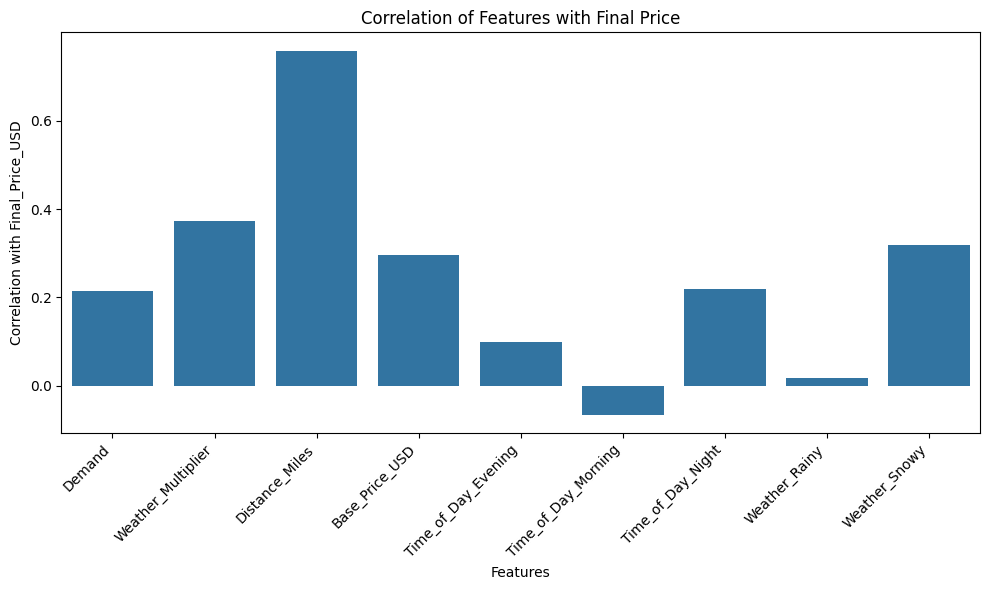

In [ ]:
# Calculate the correlations with 'Final_Price_USD'
correlations = scaled_df.corr()['Final_Price_USD'].drop('Final_Price_USD')

# Print the correlations
print(correlations.sort_values(ascending=False))

# Create a bar plot of the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Correlation with Final_Price_USD')
plt.title('Correlation of Features with Final Price')
plt.tight_layout()
plt.show()

#### The factors that most impact the Revenue (evidenced as Final Price) are:
* Distance_Miles         0.758664
* Weather_Multiplier     0.372907
* Weather_Snowy          0.318203
* Base_Price_USD         0.296847
* Time_of_Day_Night      0.218146
* Demand                 0.214130

First we will build a model based on all of the features.



In [ ]:
import statsmodels.api as sm

# Define our X and Y variables
X = scaled_df.drop(columns=['Final_Price_USD'])
y = scaled_df['Final_Price_USD']
#Add constant for intercept in statsmodels regression
X_constant = sm.add_constant(X)

# Perform OLS
model = sm.OLS(y, X_constant).fit()

#Evaluate Base model
# Check p-values and R-squared
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Final_Price_USD   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     1237.
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        03:02:16   Log-Likelihood:                -281.39
No. Observations:                1000   AIC:                             578.8
Df Residuals:                     992   BIC:                             618.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.469e-17    

The P value is 0 and the R-squared value is 0.89 which means that this is a realatively strong model. The model with be run again with cross-validation and then the errors will be checked to ensure that the linear model is the best fit for this data.

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Initialize and train
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_preds_train = model.predict(X_train)
y_preds_test = model.predict(X_test)

#Evaluate the model
mse = mean_squared_error(y_test, y_preds_test)
r2 = r2_score(y_test, y_preds_test)

print("R-squared of the model in the training set is: {}".format(model.score(X_train, y_train)))
print("R-squared of the model in the test set is: {}".format(model.score(X_test, y_test)))
print("Mean squared error of the prediction is: {}".format(mse))
print("R-Squared: {}".format(r2))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(model.score(X_test, y_test)))
print("Mean squared error of the prediction is: {}".format(mse))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.9017641164380348
R-squared of the model in the test set is: 0.8763030520356849
Mean squared error of the prediction is: 0.11868182514483928
R-Squared: 0.8763030520356849
-----Test set statistics-----
R-squared of the model in the test set is: 0.8763030520356849
Mean squared error of the prediction is: 0.11868182514483928
Mean absolute percentage error of the prediction is: 54.50121658202778


The R-squared of this model is a little worse than the original, but the MSE is relatively low.

Lets verify that this linear regression model meets the requirment of linear regressions--homeodascity (normal distribution of its errors.

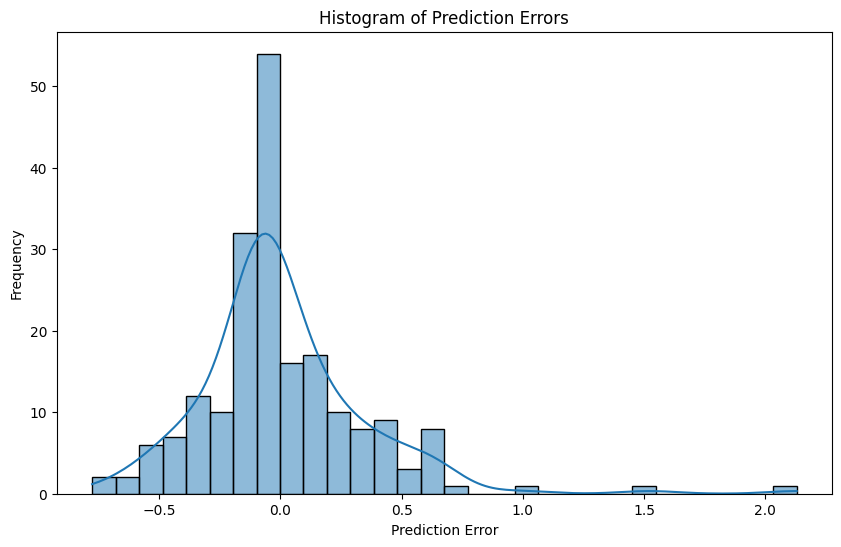

In [ ]:
# Calculate errors for the previous model
errors = y_test - y_preds_test

# Create a histogram of the errors

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

count    200.000000
mean       0.008302
std        0.345266
min       -0.776521
25%       -0.137692
50%       -0.044794
75%        0.138633
max        2.129214
Name: Final_Price_USD, dtype: float64
Shapiro-Wilk Test for Error Distribution
Statistic: 0.8826744719833802, p-value: 2.2601925757936203e-11
Error distribution is likely not normal.


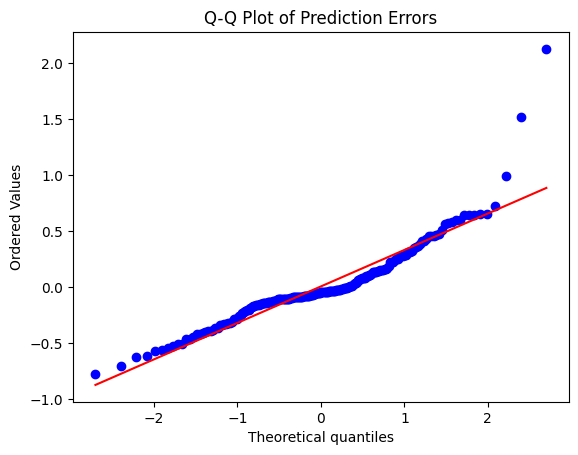

In [ ]:
# Calculate and print descriptive statistics of the errors
print(errors.describe())

# Perform a Shapiro-Wilk test for normality
statistic, p_value = stats.shapiro(errors)
print(f"Shapiro-Wilk Test for Error Distribution")
print(f"Statistic: {statistic}, p-value: {p_value}")
if p_value > 0.05:
    print("Error distribution is likely normal.")
else:
    print("Error distribution is likely not normal.")

# Create a Q-Q plot to visually assess normality
stats.probplot(errors, dist="norm", plot=plt)
plt.title("Q-Q Plot of Prediction Errors")
plt.show()

The Errors of the Linear Model are not normally distributed therefore we will have to use a different regression model.

In [ ]:
# Let's check out DTR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

dtr = DecisionTreeRegressor(random_state=32)
dtr.fit(X_train, y_train)
dtr_y_preds_train = dtr.predict(X_train)
dtr_y_preds_test = dtr.predict(X_test)

# Evaluate
print("R-squared of the model in the training set is: {}".format(dtr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(dtr.score(X_test, y_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, dtr_y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - dtr_y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 1.0
-----Test set statistics-----
R-squared of the model in the test set is: 0.9482165587784003
Mean squared error of the prediction is: 0.049683952737725814
Mean absolute percentage error of the prediction is: 47.68845562644282


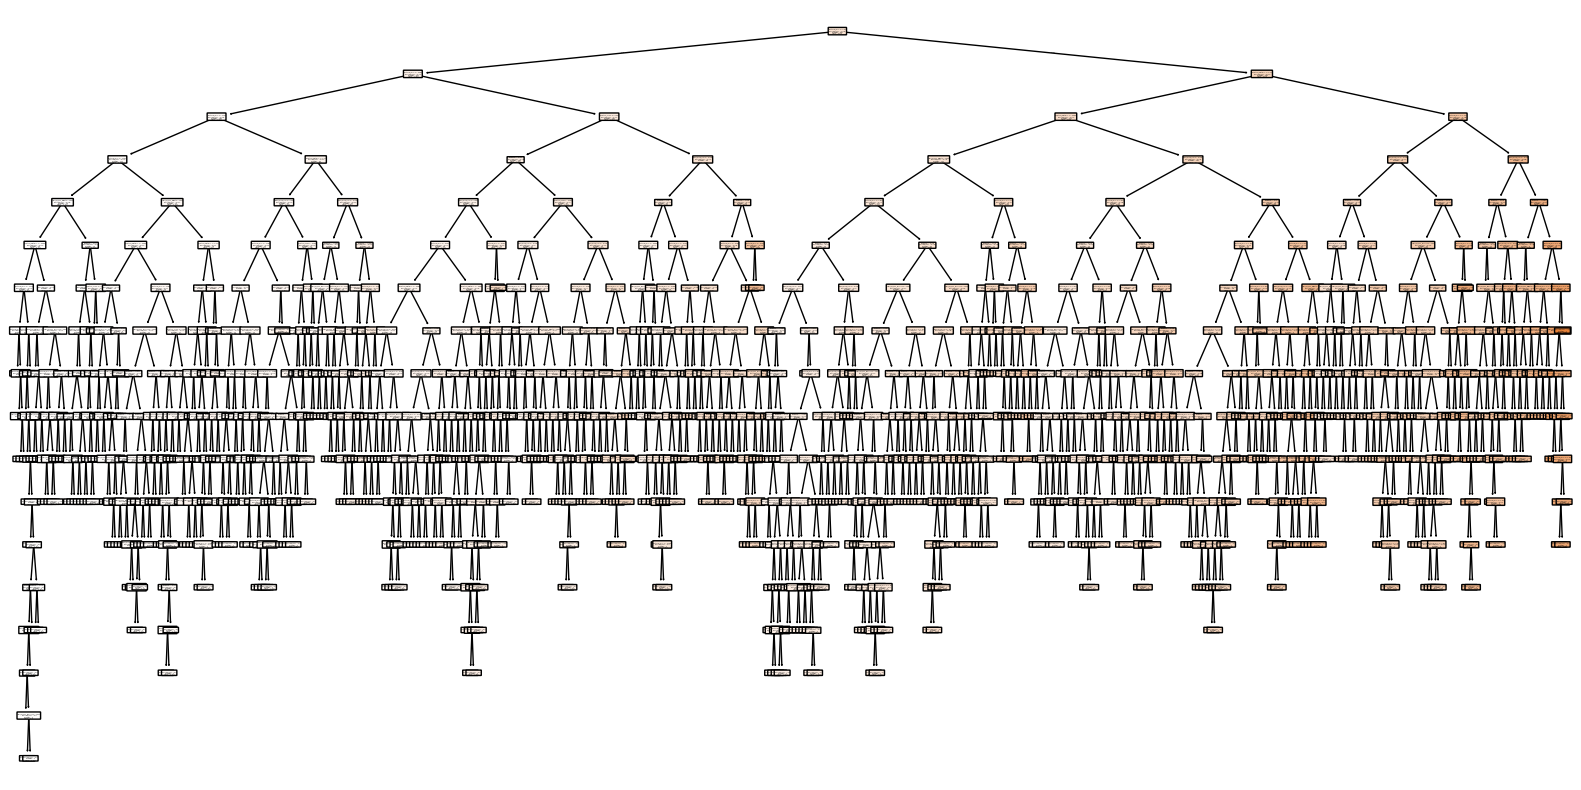

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dtr, filled=True, feature_names=X.columns, rounded=True)
plt.show()


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestRegressor(random_state=13)
# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score (negative MSE): {best_score}")

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best score (negative MSE): -0.0237263478188174


In [ ]:
bparams = best_params
rf_model = RandomForestRegressor(n_estimators=bparams['n_estimators'], max_depth=bparams['max_depth'], min_samples_split=bparams['min_samples_split'], random_state=13)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)
print(f"Random Forest - MSE: {rf_mse}, R2: {rf_r2}")
print("R-squared of the model in the training set is: {}".format(rf_model.score(X_train, y_train)))
print("R-squared of the model in the test set is: {}".format(rf_model.score(X_test, y_test)))
print("Mean squared error of the prediction is: {}".format(mse))
print("R-Squared: {}".format(r2))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(rf_model.score(X_test, y_test)))
print("Mean squared error of the prediction is: {}".format(mse))


Random Forest - MSE: 0.025548865776472165, R2: 0.9733715190456272
R-squared of the model in the training set is: 0.9968699283760086
R-squared of the model in the test set is: 0.9733715190456272
Mean squared error of the prediction is: <function mean_squared_error at 0x78ff37d9d3a0>
R-Squared: 0.8763030520356849
-----Test set statistics-----
R-squared of the model in the test set is: 0.9733715190456272
Mean squared error of the prediction is: <function mean_squared_error at 0x78ff37d9d3a0>


In [ ]:
# prompt: visualize the previous model?

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(100,50))
# Access the first tree in the forest (index 0)
plot_tree(rf_model.estimators_[0], feature_names=X.columns, filled=True, rounded=True, fontsize=14)
plt.show()


In [ ]:
# prompt: run gradient boost on dtr

import numpy as np
# Initialize and train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=32)
gbr.fit(X_train, y_train)

# Make predictions
gbr_y_preds_train = gbr.predict(X_train)
gbr_y_preds_test = gbr.predict(X_test)

# Evaluate the model
print("R-squared of the model in the training set is: {}".format(gbr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(gbr.score(X_test, y_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, gbr_y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - gbr_y_preds_test) / y_test)) * 100))


R-squared of the model in the training set is: 0.9961031066533403
-----Test set statistics-----
R-squared of the model in the test set is: 0.9862215300610525
Mean squared error of the prediction is: 0.013219840804231775
Mean absolute percentage error of the prediction is: 23.04179941707286


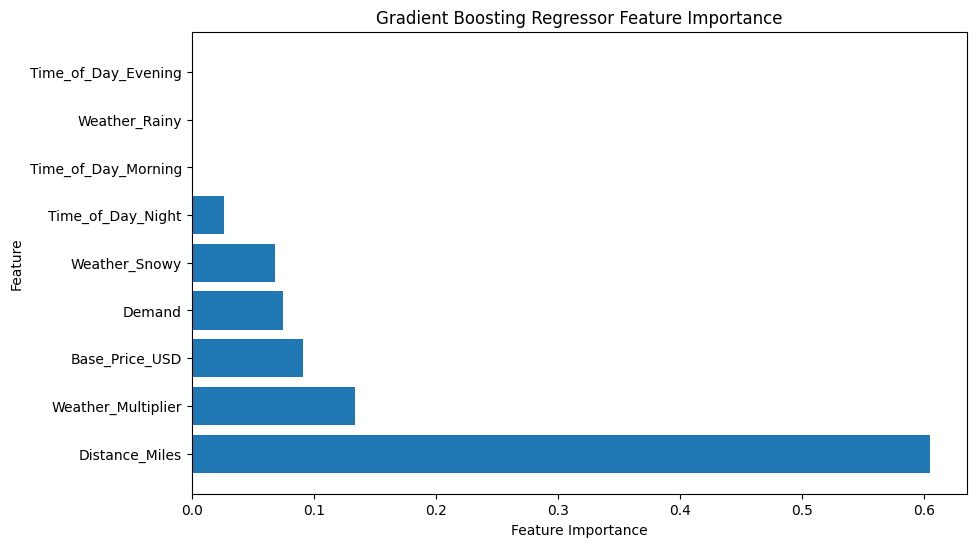

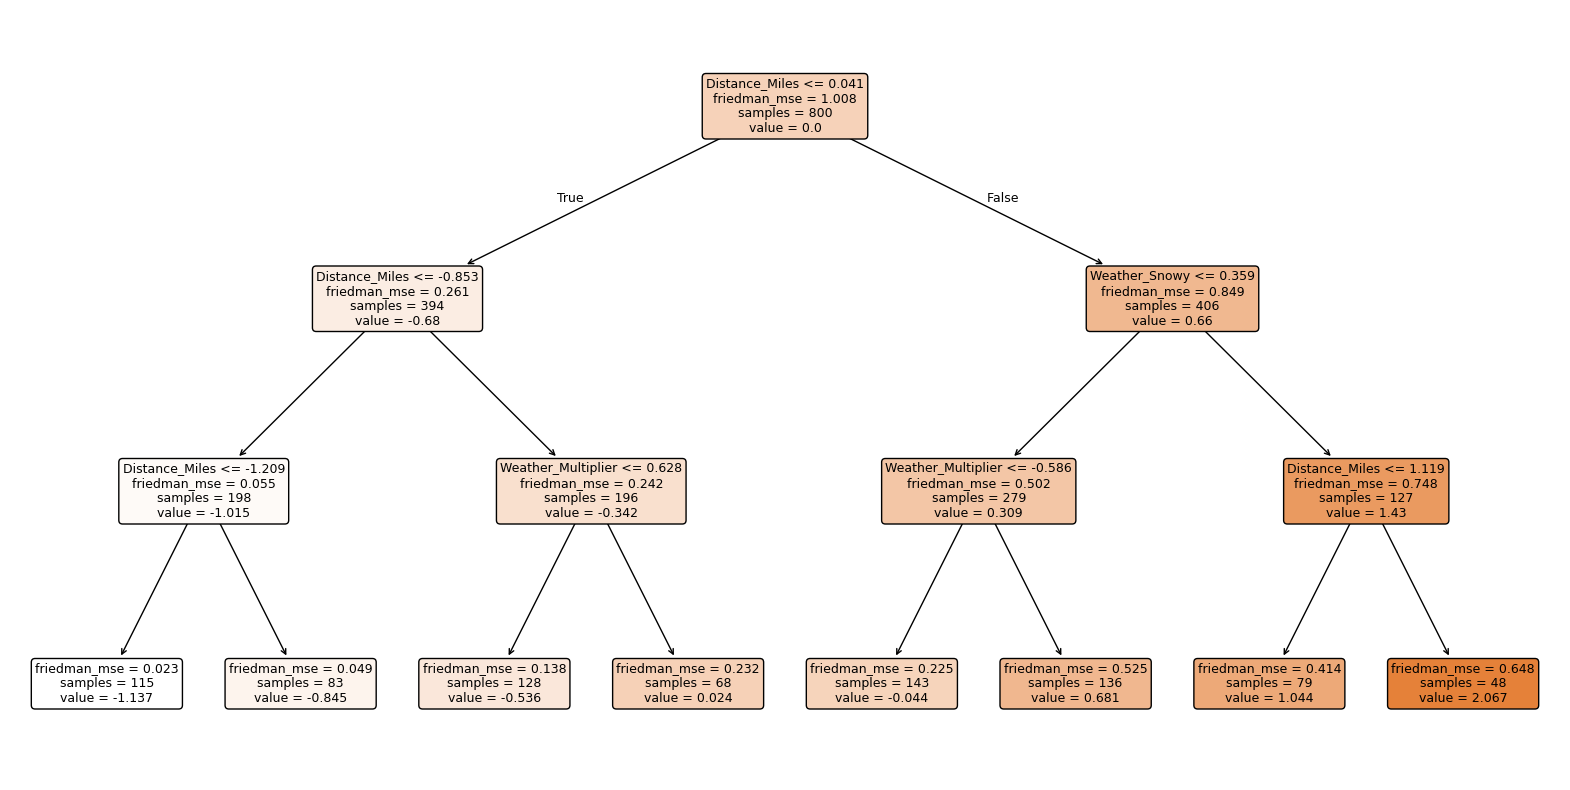

In [ ]:
# prompt: visualize gbr

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
# Assuming 'gbr' is your trained GradientBoostingRegressor model
# and 'X_train' and 'y_train' are your training data

# Feature Importance Plot
feature_importance = gbr.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a pandas DataFrame

# Create a DataFrame for easier sorting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Regressor Feature Importance')
plt.show()

# Plot individual trees (optional - can be computationally expensive for large forests)
# You can visualize individual trees in a gradient boosting model
# For example, to plot the first tree:

from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(gbr.estimators_[0, 0], feature_names=X_train.columns, filled=True, rounded=True)
plt.show()


In [ ]:
# Initalize and train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=32)
gbr.fit(X_train, y_train)

# Make predictions
gbr_y_preds_train = gbr.predict(X_train)
gbr_y_preds_test = gbr.predict(X_test)
# Evaluate
print("R-squared of the model in the training set is: {}".format(gbr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(gbr.score(X_test, y_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(y_test, gbr_y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - gbr_y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.9961031066533403
-----Test set statistics-----
R-squared of the model in the test set is: 0.9862215300610525
Mean squared error of the prediction is: 0.013219840804231775
Mean absolute percentage error of the prediction is: 23.04179941707286


In [ ]:
from sklearn.metrics import mean_squared_error as mse, r2_score
import numpy as np

models = [dtr, rf_model,gbr]
model_names = ['Random Tree Regression', 'Random Forest Regression', 'Gradient Boost Regression']

for name, model in zip(model_names, models):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R-squared: {r2:.2f}\n")


Random Tree Regression:
MSE: 0.05
R-squared: 0.95

Random Forest Regression:
MSE: 0.03
R-squared: 0.97

Gradient Boost Regression:
MSE: 0.01
R-squared: 0.99



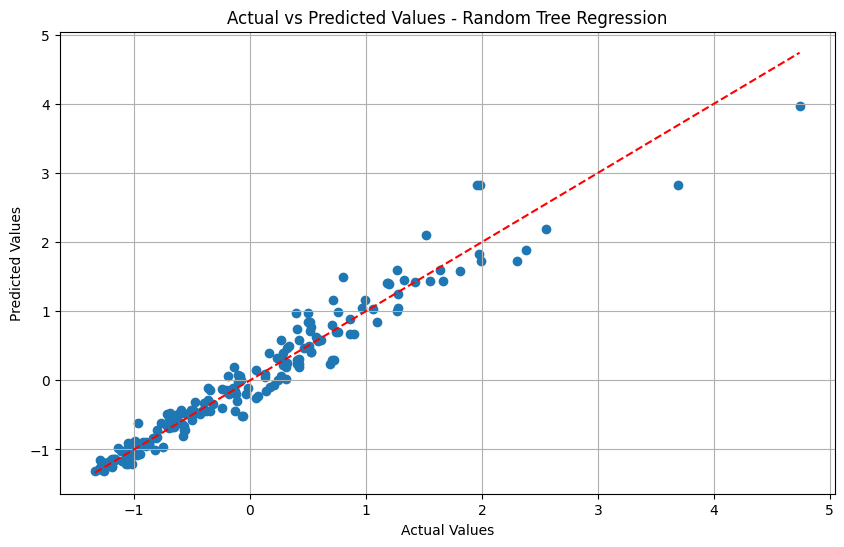

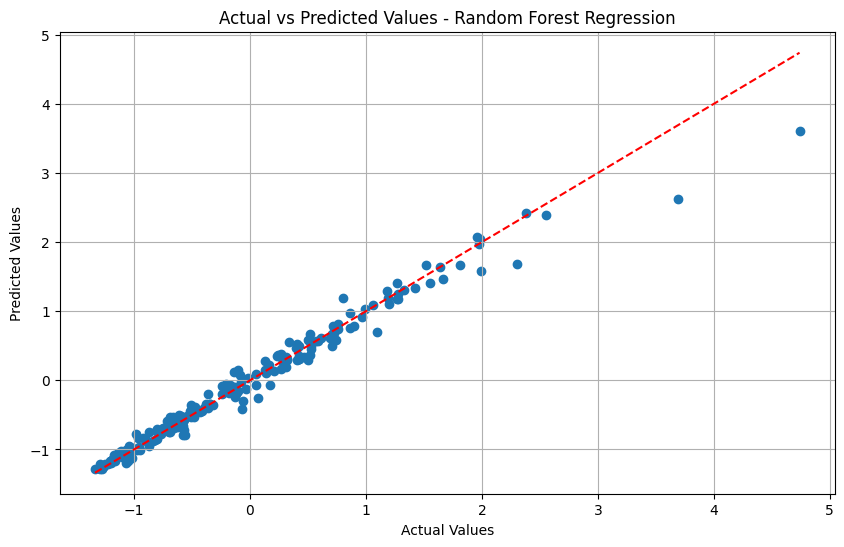

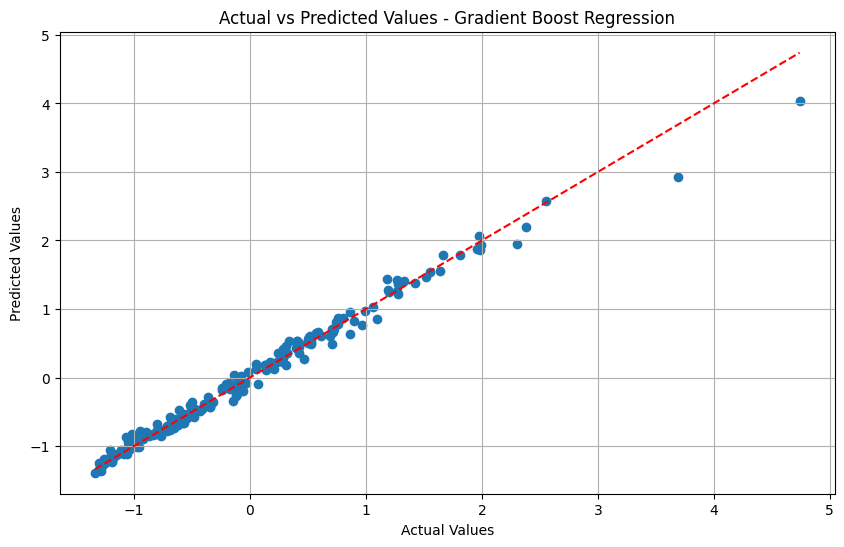

In [ ]:
# prompt: visualize the errors ( actual vs perdicted) for each model individually

import matplotlib.pyplot as plt

models = [dtr, rf_model, gbr]
model_names = ['Random Tree Regression', 'Random Forest Regression', 'Gradient Boost Regression']

for name, model in zip(model_names, models):
    y_pred = model.predict(X_test)
    errors = y_test - y_pred

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values - {name}')
    plt.grid(True)
    plt.show()

### The Gradient Boost Regression is the best model because it has the highest R-squared and lowest MSE

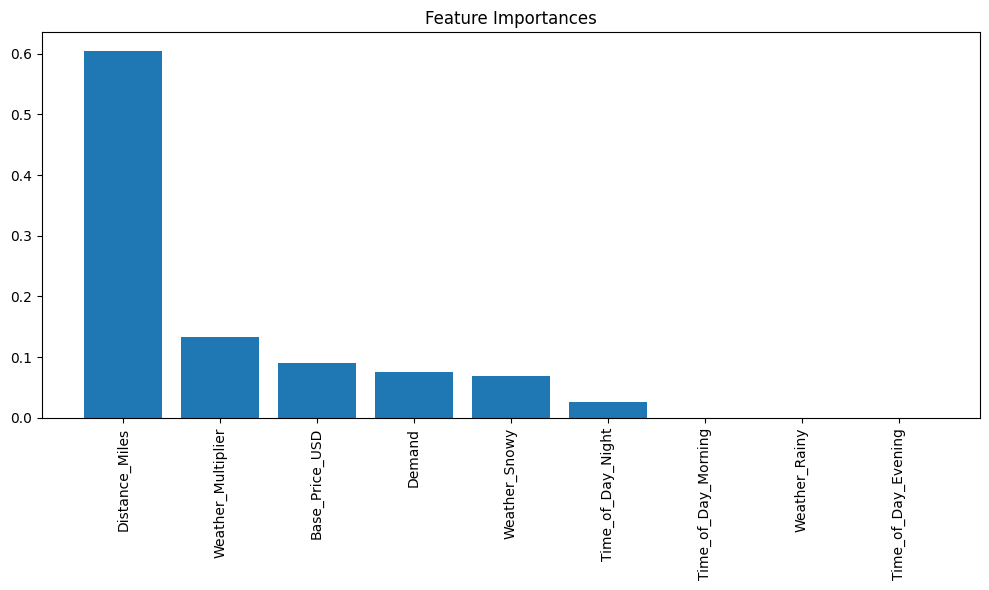

In [ ]:
best_model = gbr

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Forecasting Model
For forecasting future prices:
1. Create time-based features:

In [ ]:
df['Date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='H')
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Hour'] = df['Date'].dt.hour

<ipython-input-39-27d7a9f0c281>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='H')


2. Split data into train and test sets:

In [ ]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

3. Build and evaluate a forecasting model

MSE: 15065.598424159456


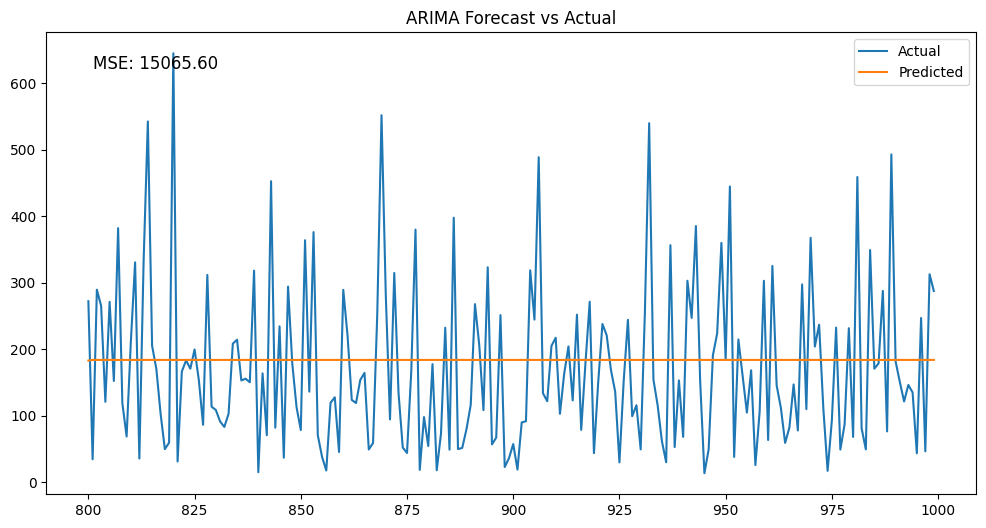

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

train_numeric = train.select_dtypes(exclude=['object'])


ARIMA_model = ARIMA(train_numeric['Final_Price_USD'], order=(1,1,1))
ARIMA_results = ARIMA_model.fit()

# Make predictions
predictions = ARIMA_results.forecast(steps=len(test))

# Evaluate the model
mse = mean_squared_error(test['Final_Price_USD'], predictions)
print("MSE: {}".format(mse))

# Visualize the results
plt.figure(figsize=(12,6))
plt.plot(test.index, test['Final_Price_USD'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title('ARIMA Forecast vs Actual')
plt.legend()


# Highlight the MSE visually
plt.text(0.05, 0.95, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Best score: 0.03
Root Mean Squared Error: 0.19
R-squared Score: 0.96


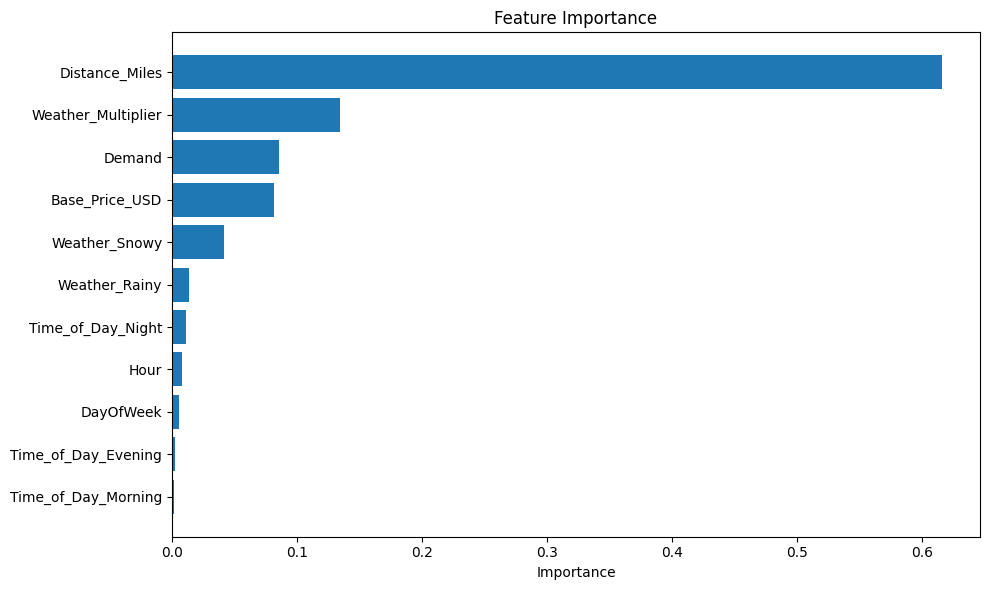

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Load and prepare the data
df = df
X = df.drop(columns=['Final_Price_USD', 'Date'])
y = scaled_df['Final_Price_USD']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define the parameter grid
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {-grid_search.best_score_:.2f}")

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Feature importance
feature_importance = best_model.named_steps['rf'].feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importance)), sorted_importance)
plt.yticks(range(len(sorted_importance)), sorted_features)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


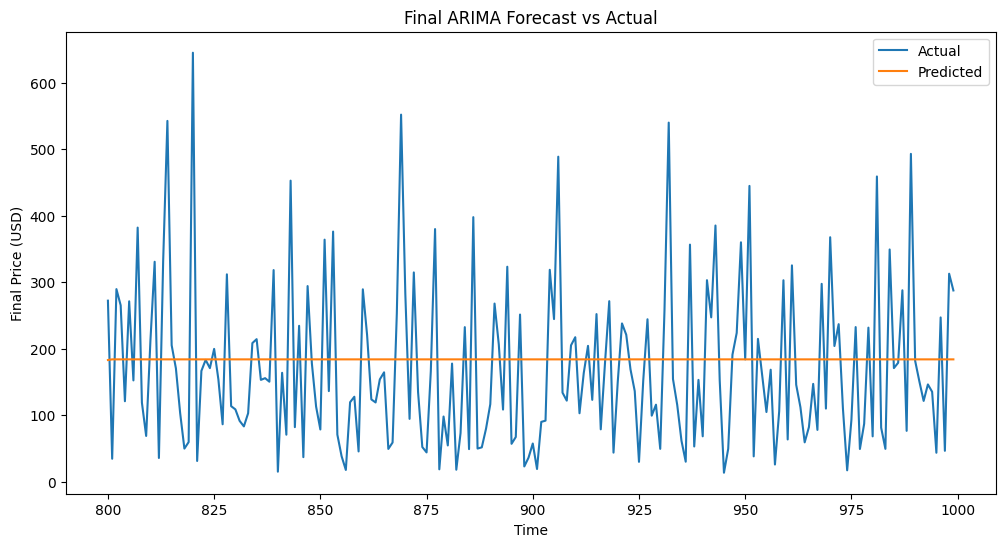

In [ ]:
# prompt: visualize the ARIMA forecast above

import matplotlib.pyplot as plt

# Assuming 'predictions' and 'test' are defined from the previous ARIMA model fitting
# and that 'test' is a pandas DataFrame with an index representing time and
# a 'Final_Price_USD' column.

plt.figure(figsize=(12,6))
plt.plot(test.index, test['Final_Price_USD'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title('Final ARIMA Forecast vs Actual')
plt.xlabel("Time") # Add x-axis label
plt.ylabel("Final Price (USD)") # Add y-axis label
plt.legend()

plt.show()


## **Limitations**:
**Data**: The data is synthetic and assumed. It would be immensely more informative if it were genuine from a client.


**Dashboard**: This element is limited, because is still code and not a visual one.

##**Suggestons**
Taking data with additional time data parameters such as day of week, month, year would help better understand demand. (Also discuss scalability of the model for future data and how Ride can adapt the pipeline for new inputs)
